# Machine Learning for Modelling: Supervised Learning

## Exam Project: Image classification using SIFT/Bag of words coupled with traditional classifiers and CNNs



In [ ]:
from google.colab import drive
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torchvision.transforms as transforms
import zipfile
from sklearn.cluster import MiniBatchKMeans

from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from torchvision import transforms
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC

from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from PIL import Image
import torch
import cv2
import numpy as np
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if train_on_gpu else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


In [ ]:

# Mount Google Drive
drive.mount('/content/drive')

# Set the path to the ZIP file of the dataset on Google Drive
zip_path = '/content/drive/MyDrive/Supervised/TinyImageNet.zip'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Task 1:  Data Preprocessing: The student should preprocess the images by resizing them to a common size, converting them to grayscale or RGB, and normalizing the pixel values.

In [ ]:
# Extract the dataset from the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

# Set the path to the extracted dataset directory
dataset_dir = '/content/dataset/TinyImageNet'



## Step 1: Preprocessing

In [ ]:

def preprocess_image(image_path):
    # Load the image
    image = Image.open(image_path)

    # Define the transformation
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Resize to 64x64 pixels
        transforms.ToTensor(),  # Convert the image to PyTorch Tensor data type
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
    ])

    # Apply the transformation to the image
    image = transform(image)

    return image

In [ ]:
import os

def read_data(file_path, root_dir):
    img_paths, labels = [], []



    with open(file_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        line = line.strip()
        image_path, label = line.split() # assuming path and label are separated by a space
        img_paths.append(os.path.join(root_dir, image_path))
        labels.append(int(label))



    return img_paths, labels

In [ ]:



train_file_path = 'dataset/TinyImageNet/train.txt'
val_file_path = 'dataset/TinyImageNet/val.txt'
root_dir = 'dataset/TinyImageNet'

train_img_paths, train_labels = read_data(train_file_path, root_dir)

# images_train = [preprocess_image(image_path) for image_path in train_img_paths]
print(train_img_paths[9999:10005])



['dataset/TinyImageNet/train/9/9_999.jpg', 'dataset/TinyImageNet/train/10/10_0.jpg', 'dataset/TinyImageNet/train/10/10_1.jpg', 'dataset/TinyImageNet/train/10/10_2.jpg', 'dataset/TinyImageNet/train/10/10_3.jpg', 'dataset/TinyImageNet/train/10/10_4.jpg']


In [ ]:
val_file_path = 'dataset/TinyImageNet/val.txt'
val_img_paths, val_labels = read_data(val_file_path, root_dir)

In [ ]:
val_img_paths

In [ ]:
train_labels[4648]

4

In [ ]:
val_labels[4648]

46

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels,transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        image=np.array(image,dtype=np.float32)
        image=torch.tensor(image).unsqueeze(0)
        label = self.labels[idx]
        label=torch.tensor(label).unsqueeze(0)

        # Convert image to grayscale
        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'label': torch.tensor(label).float()}
        return sample

In [ ]:
 # Define ImageDataset class
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path)

        # Convert image to grayscale
        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'label': torch.tensor(label).float()}
        return sample

        #return image, label



In [ ]:
# Define the transformation
# transform = transforms.Compose([
#     transforms.Resize((64, 64)),  # Resize to 64x64 pixels
#     # transforms.Grayscale(),  # Convert to grayscale
#     transforms.ToTensor(),  # Convert the image to PyTorch Tensor data type
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#     std=[0.229, 0.224, 0.225]
#  )])

import pickle

transform_train = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
 )])

transform_val = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
 )])

train_dataset = ImageDataset(train_img_paths, train_labels, transform=transform_train)
val_dataset = ImageDataset(val_img_paths, val_labels,transform=transform_val)

In [ ]:
val_dataset

## Task 2: Feature Extraction using SIFT and Bag of Words: The student should extract features from the images using ScaleInvariant Feature Transform (SIFT) (or similar approaches) and Bag of Words (BoW) representation and train a traditional classifier (e.g., Support Vector Machines (SVMs), Random Forests, or k-Nearest Neighbors (k-NN)) to classify them.

### Some resources:


https://machinelearningknowledge.ai/image-classification-using-bag-of-visual-words-model/

https://www.youtube.com/watch?v=PRceoMWcv1U&ab_channel=DigitalSreeni

https://www.youtube.com/watch?v=54N_8J_cl5Y&ab_channel=MoacirAntonelliPonti




In [ ]:
!pip install opencv-python
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip show opencv-python

Name: opencv-python
Version: 4.7.0.72
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/opencv/opencv-python
Author: 
Author-email: 
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, numpy, numpy, numpy
Required-by: dopamine-rl, imgaug


In [ ]:
#This is for bag of words
def preprocess_image(image_path):
     img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale while reading
     if img is None:
         print(f'Error loading image {image_path}')
         return None
     img = cv2.resize(img, (64, 64))  # Resize to 64x64

     return img

In [ ]:

# SIFT Feature Extractor
sift = cv2.xfeatures2d.SIFT_create()
#brisk = cv2.BRISK_create(30)

def extract_features(image):
    if image is None:
        return None
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is None:
        descriptors = np.zeros((1, 128))  # Return a dummy descriptor for images with no keypoints
    return descriptors



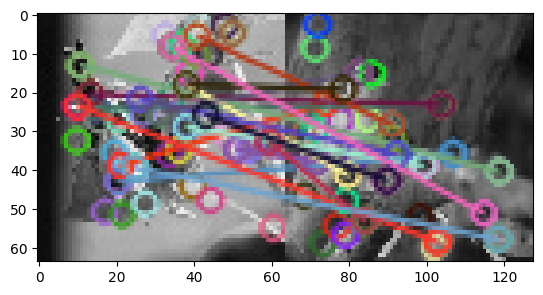

(<matplotlib.image.AxesImage at 0x7f456a863cd0>, None)

In [ ]:
import matplotlib.pyplot as plt

# Select two images
image1 = images_train[1003]  # Replace with your image
image2 = images_train[1004]  # Replace with your image

# Extract features
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

# Create BFMatcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches
matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches, None, flags=0)


plt.imshow(matched_image),plt.show()


In [ ]:
descriptors_list = [extract_features(image) for image in images_train]

# Remove None values from descriptors_list
descriptors_list = [descriptors for descriptors in descriptors_list if descriptors is not None]

descriptors_list = [desc.astype(np.float32) for desc in descriptors_list if desc is not None]

# Before fitting the model, you can check the dtypes of your descriptors to make sure they are float32:
for desc in descriptors_list:
    if desc.dtype != np.float32:
        print(f"Unexpected dtype: {desc.dtype}")


In [ ]:
num_clusters = 100
kmeans = MiniBatchKMeans(n_clusters=num_clusters)
classifier = SVC(kernel='linear')

# Transform descriptors to features
def transform_bovw(descriptors_list, kmeans, num_clusters):
    bovw_features = []
    for descriptors in descriptors_list:
        histogram = np.zeros(num_clusters)
        if descriptors is not None:
            predicted_cluster = kmeans.predict(descriptors)
            for i in predicted_cluster:
                histogram[i] += 1
        bovw_features.append(histogram)
    return bovw_features

# Fit the model
def fit_bovw(descriptors_list, labels, kmeans, classifier):
    all_descriptors = np.vstack(descriptors_list)
    kmeans.fit(all_descriptors)
    features = transform_bovw(descriptors_list, kmeans, num_clusters)
    classifier.fit(features, labels)

# Predict classes
def predict_bovw(descriptors_list, kmeans, classifier, num_clusters):
    features = transform_bovw(descriptors_list, kmeans, num_clusters)
    return classifier.predict(features)

In [ ]:
# Train test split
X_train, X_val, y_train, y_val = train_test_split(descriptors_list, train_labels, test_size=0.2, random_state=42)


In [ ]:
# Training
fit_bovw(X_train, y_train, kmeans, classifier)

# Validation
y_pred = predict_bovw(X_val, kmeans, classifier, num_clusters)
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred)}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Validation Accuracy: 0.0597


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


# Compute confusion matrix
conf_mat = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(conf_mat)

# Compute precision, recall, and f1-score
clf_report = classification_report(y_val, y_pred)
print("Classification Report:")
print(clf_report)


Confusion Matrix:
[[17  0  0 ...  1  0  1]
 [ 3 12  1 ...  0  2  2]
 [ 3  5  1 ...  1  3  3]
 ...
 [ 1  3  0 ...  4  4  1]
 [ 3  1  0 ...  1 10  6]
 [ 5  0  0 ...  0  1 30]]
Classification Report:
              precision    recall  f1-score   support

           0       0.05      0.09      0.06       200
           1       0.06      0.06      0.06       189
           2       0.02      0.00      0.01       217
           3       0.05      0.03      0.03       195
           4       0.06      0.03      0.04       190
           5       0.04      0.04      0.04       186
           6       0.05      0.03      0.03       221
           7       0.05      0.05      0.05       194
           8       0.00      0.00      0.00       220
           9       0.03      0.04      0.03       193
          10       0.00      0.00      0.00       200
          11       0.02      0.02      0.02       210
          12       0.03      0.01      0.02       211
          13       0.01      0.01      0.01   

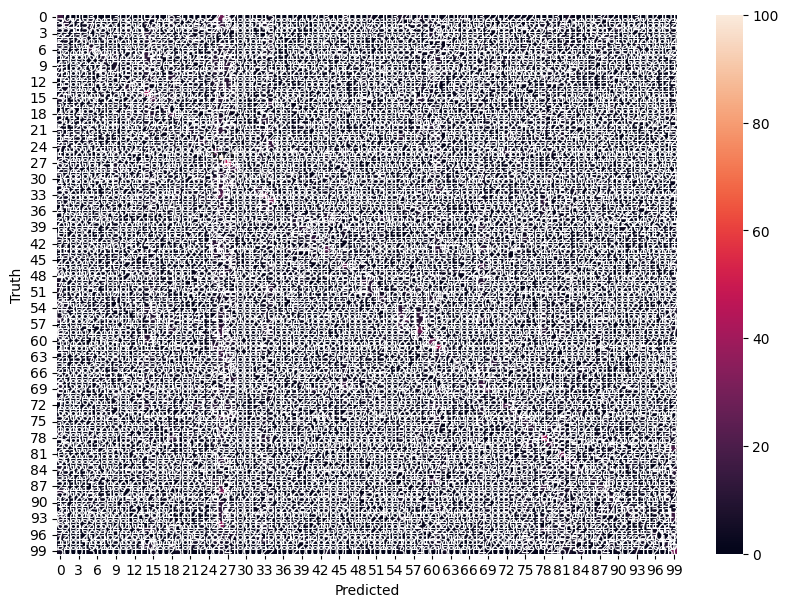

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Using Seaborn's heatmap to visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
len(X_train)

88000

In [ ]:
np.unique(train_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
# Extract classes
unique_labels = np.unique(train_labels)

# Define reduced labels (first 3 classes)
reduced_labels = unique_labels[:3]

# Filter train_images and train_labels for the reduced classes
reduced_train_images = [image for image, label in zip(images_train, train_labels) if label in reduced_labels]
reduced_train_labels = [label for label in train_labels if label in reduced_labels]

print(len(reduced_train_images))  # Verify the length of reduced_train_images
print(len(reduced_train_labels))  # Verify the length of reduced_train_labels


3000
3000


## 3. Convolutional Neural Networks: The student should train a convolutional neural network (CNN) on the preprocessed images to classify them into different categories. The student should experiment with different architectures such as VGG, ResNet, Inception, etc.





In [ ]:
bs=32
trainloader =DataLoader(train_dataset, batch_size=bs,
                                          shuffle=True, num_workers=0)
valloader = DataLoader(val_dataset, batch_size=1,
                                         shuffle=False, num_workers=0)
print(len(trainloader)*bs,len(valloader))

100000 10000


In [ ]:
import torchvision
import torch.nn as nn

net=torchvision.models.vgg19(weights='VGG19_Weights.IMAGENET1K_V1') #weights=None for random weights **********
print(net)
num_ftrs = net.classifier[0].in_features
# Here the size of each output sample is set to 1.
net.classifier = nn.Sequential(nn.Linear(num_ftrs, 512),
                               nn.ReLU(),
                               nn.Linear(512,256),
                               nn.ReLU(),
                               nn.Linear(256, 100)
                               )
print("*******************************************")
print(net)
net = net.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
import torch.optim as optim
import torch.nn.functional as F
from scipy.stats import spearmanr, pearsonr
import itertools
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt


criterion = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = CosineAnnealingLR(optimizer,
                              T_max = len(trainloader)*5, # Maximum number of iterations.
                             eta_min = 1e-5)

In [ ]:
from torchsummary import summary
summary(net, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

In [ ]:
for epoch in range(3):  # loop over the dataset multiple times
    running_loss = 0.0
    k=0
    gt_labels=[]
    pr_labels=[]
    net.train()
    for i, data in enumerate(trainloader):
        # get the inputs
        inputs, labels = data["image"], data["label"]
        gt_labels.append(labels)
        inputs=inputs.to(device)
        labels=labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs[:,0], labels)
        pr_labels.append(outputs[:,0].detach().cpu())
        loss.backward()
        optimizer.step()
        scheduler.step()
        k+=1
        # print statistics
        running_loss += loss.item()
        if (i % (len(trainloader)//10))==0:
            gt_labels = np.stack(
                list(itertools.chain.from_iterable(gt_labels))).squeeze()
            pr_labels = np.stack(
                list(itertools.chain.from_iterable(pr_labels))).squeeze()
            s = spearmanr(gt_labels, pr_labels)[0]
            p = pearsonr(gt_labels, pr_labels)[0]
            print('[%d, %d] loss: %.4f\tPLCC: %.3f\tSROCC: %.3f\tlr: %.6f' %
                  (epoch + 1, i + 1, running_loss / k,p,s,optimizer.param_groups[-1]['lr']))
            gt_labels=[]
            pr_labels=[]
            running_loss = 0.0
            k=0
    running_loss = 0.0
    k=0
    gt_labels=[]
    pr_labels=[]
    net.eval()
    for i, data in enumerate(valloader):
        # get the inputs
        inputs, labels = data["image"], data["label"]
        gt_labels.append(labels.item())
        inputs=inputs.to(device)
        labels=labels.to(device)
        with torch.no_grad():
          outputs = net(inputs)

        pr_labels.append(outputs.item())
        loss = criterion(outputs[:,0], labels)
        k+=1
        # print statistics
        running_loss += loss.item()

    gt_labels = np.stack(gt_labels)
    pr_labels = np.stack(pr_labels)
    s = spearmanr(gt_labels, pr_labels)[0]
    p = pearsonr(gt_labels, pr_labels)[0]
    print('Validation loss: %.6f\tPLCC: %.3f\tSROCC: %.3f' % ( running_loss / k,p,s))
    plt.scatter(pr_labels,gt_labels)
    plt.xlabel("AGE Predicted")
    plt.ylabel("AGE GT")
    plt.title("PLCC: %.3f\nSROCC: %.3f"%(p,s))
    plt.show()
    torch.save(net.state_dict(), f"net_last_e{epoch}.pth")
print('Finished Training')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TypeError: ignored

## 4. The students can choose to cast the problem as supervised learning or self-supervised learning.

# 5. Model Evaluation: The student should evaluate the performance of the models using metrics such as accuracy, precision, recall, and F1-score.

In [ ]:
# Compute precision, recall, and f1-score
clf_report = classification_report(y_val, y_pred)
print("Classification Report:")
print(clf_report)

# 6. Hyperparameter Tuning: The student should fine-tune the hyperparameters of the models to achieve better performance